In [1]:
from FASTA import fasta
from VARIANT import mutation
from DRUG_ID import drug_id
from DRUG_SMILES import drug_smiles
from Model import Prediction

In [2]:
def sequence_generate(pdb):
    seq=str(fasta(pdb))
    return seq

In [3]:
def cid_generate(pdb):
    cid=str(drug_id(pdb))
    return cid

def smiles_generate(cid):
    smile=str(drug_smiles(cid))
    return smile

In [35]:
pdb=input("Enter the PDB ID:")
var_list=[]
smile=smiles_generate(cid_generate(pdb))
seq=sequence_generate(pdb)
print("Drug and Target associated with PDB ID ",pdb,"is:")
print("SMILES: ",smile)
print("Sequence: ",seq)

Drug and Target associated with PDB ID  1A7V is:
SMILES:  Cc1c2n3c(c1CCC(=O)O)C=C4C(=C(C5=[N]4[Fe]36[N]7=C(C=C8N6C(=C5)C(=C8C)C=C)C(=C(C7=C2)C)C=C)C)CCC(=O)O
Sequence:  QTDVIAQRKAILKQMGEATKPIAAMLKGEAKFDQAVVQKSLAAIADDSKKLPALFPADSKTGGDTAALPKIWEDKAKFDDLFAKLAAAATAAQGTIKDEASLKANIGGVLGNCKSCHDDFRAKKS


In [5]:
def mutation_chain(pdb):
    variations=mutation(pdb)
    list=variations.Result()
    # print(list)
    var_list.append(list)
    return list

In [6]:
# (mutation_chain(pdb))

DATA GENERATION & PRE-PROCESSING

In [6]:
import pandas as pd

# Define the path to the CSV file
csv_file_path = "protein_change_dataset.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)
s=df["PDB ID"][0]
for i in range(0,len(df["PDB ID"])):
    if(s!=(df["PDB ID"][i])):
        s=df["PDB ID"][i]
        df["SMILES"][i]=smiles_generate(cid_generate(df["PDB ID"][i]))
        smile=df["SMILES"][i]
    else:
        df["SMILES"][i]=smile
c=0
for i in range(len(df["Mutation_PDB"])):
    if(len(df["Mutation_PDB"][i])==6):
       c=c+1
        

# df.to_csv(csv_file_path, index=False)
nan_count = df['SMILES'].isnull().sum()
# print((df["Sequence"][255][58]))
# max_length = df['Sequence'].str.len().max()
print(nan_count)

In [7]:
for i in range(len(df["PDB ID"])):
    if(df["PDB ID"][i]==pdb):
        smiles=df["SMILES"][i]
        break

DRUG Featurization - Molecular Embeddings

In [12]:
pip install rdkit

Note: you may need to restart the kernel to use updated packages.


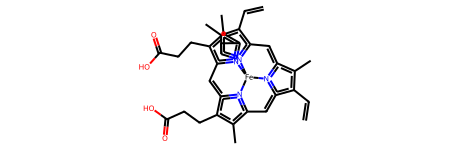

In [9]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
mol=Chem.MolFromSmiles(smiles)
mol

In [10]:
import networkx as nx
import torch
import torch_geometric as pyg
import torch.nn as nn
import numpy as np
import random

In [12]:
nx_graph=[]
length=[]
# Convert the SMILES string to an RDKit molecule object
for x in range(0,1):
    nx_graph.append(nx.Graph())
    l=0
    # Add nodes  to the graph
    for atom in mol.GetAtoms():
    #     print(atom.GetSymbol())
        l=l+1
        atom_idx = atom.GetIdx()
        atom_symbol = atom.GetSymbol()
        nx_graph[x].add_node(atom_idx, atom_symbol=atom_symbol)
    length.append(l)
    # print(length)
    label_list=[]
    for i in range(l):
        label_list.append('C')
    # Add edges  to the graph
    for bond in mol.GetBonds():
        start_atom_idx = bond.GetBeginAtom().GetIdx()
        s_atom=bond.GetBeginAtom().GetSymbol()
    #     s_atom_idx= s_atom
        end_atom_idx = bond.GetEndAtom().GetIdx()
        e_atom=bond.GetEndAtom().GetSymbol()
        bond_type = bond.GetBondTypeAsDouble()
        nx_graph[x].add_edge(start_atom_idx, end_atom_idx, bond_type=bond_type)
        label_list[start_atom_idx]=s_atom
        label_list[end_atom_idx]=e_atom
    pos = nx.spring_layout(nx_graph[x])
    # nx.draw(nx_graph[x], pos, with_labels=True,node_size=500, node_color="lightblue")
print(length)

gnn_arr_drug=[]
# print(len(data))
for x in range(0,1):
    data1 = pyg.utils.from_networkx(nx_graph[x])
    seed = 40
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Create one-hot encoding for 'atom_symbol'
    atom_symbols = [nx_graph[x].nodes[node]['atom_symbol'] for node in nx_graph[x].nodes()]
    unique_symbols = list(set(atom_symbols))
    symbol_to_index = {symbol: i for i, symbol in enumerate(unique_symbols)}
    one_hot_encoded_symbols = torch.eye(len(unique_symbols))[torch.tensor([symbol_to_index[symbol] for symbol in atom_symbols])]
    data1.x = one_hot_encoded_symbols

    class GNNModel(nn.Module):
        def __init__(self, node_input_dim, hidden_dim):
            super(GNNModel, self).__init__()
            self.conv1 = pyg.nn.GCNConv(node_input_dim, hidden_dim)
            self.conv2 = pyg.nn.GCNConv(hidden_dim, hidden_dim)

        def forward(self, data1):
            x, edge_index = data1.x, data1.edge_index
            x = self.conv1(x, edge_index)
            x = self.conv2(x, edge_index)
            return x
    # Create an instance of your GNN model
    node_input_dim = one_hot_encoded_symbols.size(1)  # Input dimension is the number of one-hot encoded symbols
#     print(node_input_dim)
    hidden_dim = 167
    gnn_model = GNNModel(node_input_dim, hidden_dim)
    gnn_model.eval()
    node_features = gnn_model(data1)
    node_features_list = node_features.tolist()
    gnn_feature_values=[]
    for i in range(0,hidden_dim):
        sum1=0.0
        for j in range(0,length[x]):
            sum1+=node_features[j][i]
        gnn_feature_values.append(sum1.item())

#     print(gnn_feature_values)
    gnn_arr_drug.append(gnn_feature_values)

    flattened_list = [item for sublist in node_features_list for item in sublist]

print((gnn_arr_drug[0]))

[43]
[4.6786723136901855, 5.5968475341796875, -0.7502793073654175, 6.403048992156982, 1.0044703483581543, -0.4731263518333435, -0.3815072774887085, 2.323955535888672, 0.5431624054908752, 4.273020267486572, 3.0142087936401367, 1.685444712638855, 1.2771445512771606, 6.472745418548584, 0.6425771713256836, -4.0386247634887695, -7.704404830932617, 2.1157164573669434, -0.014995239675045013, -3.263251304626465, -6.184858322143555, -6.8933024406433105, -5.687821388244629, 0.05528359115123749, -0.3715476393699646, -0.4925377368927002, 0.19259656965732574, 1.1635491847991943, 3.735762119293213, -2.052586078643799, -3.7327113151550293, 3.8020834922790527, -1.8493273258209229, 5.251523971557617, -0.6071771383285522, 0.4379674792289734, 2.4669508934020996, -4.9527587890625, 1.5813366174697876, 0.37822917103767395, 1.9886891841888428, -7.110009670257568, -0.6477255821228027, -0.8576245307922363, 1.4728962182998657, -0.5923424363136292, -1.7908190488815308, -1.3970917463302612, 0.37804004549980164, 2

Protein Featurization - Word2Vec

In [6]:
pip install word2vec

     ---------------------------------------- 0.0/42.3 kB ? eta -:--:--
     ------------------ ------------------- 20.5/42.3 kB 640.0 kB/s eta 0:00:01
     ------------------ ------------------- 20.5/42.3 kB 640.0 kB/s eta 0:00:01
     ------------------------------------ - 41.0/42.3 kB 279.3 kB/s eta 0:00:01
     -------------------------------------- 42.3/42.3 kB 256.6 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=515233 sha256=e0ab0ecd26d03874bc0042db017852c0214958705aac7a379013c18c44433ecd
  Stored in directory: c:\users\sasin\appdata\local\pip\cache\wheels\53\1f\b2\ff3d47b2a8bd249985b0c59210004a85d70ec90b

In [13]:
from gensim.models import Word2Vec
import numpy as np

# Example protein sequence
protein_sequence = seq

# Tokenize the protein sequence into individual amino acids
amino_acids = [aa for aa in protein_sequence]

# Train a Word2Vec model on a corpus of protein sequences
# For demonstration purposes, we'll use a small corpus consisting of the input sequence itself
corpus = [amino_acids]
word2vec_model = Word2Vec(sentences=corpus, vector_size=167, window=5, min_count=1, sg=1)

# Convert each amino acid into its corresponding Word2Vec embedding vector
embedding_size = word2vec_model.vector_size
sequence_vectors = [word2vec_model.wv[aa] for aa in amino_acids]

# Aggregate the embedding vectors to obtain a single numerical vector representation for the protein sequence
protein_vector = np.mean(sequence_vectors, axis=0)

# Print the numerical vector representation
print("Numerical vector representation of the protein sequence(Word2Vec):")

print((protein_vector[0:100]))

Numerical vector representation of the protein sequence(Word2Vec):
[ 2.42941431e-04  1.56164588e-03  2.27107620e-03  3.32985015e-04
 -4.02350537e-03  1.79672061e-04  5.04687941e-03 -1.01163045e-04
 -7.80225906e-04 -3.20823048e-03  1.79419620e-03  5.16602122e-05
 -5.00847294e-04 -2.44652457e-03 -2.45368108e-03  3.37657460e-04
 -1.08507206e-03 -8.36534542e-04 -2.29156972e-03 -2.95604183e-03
  3.25304078e-04  1.74114702e-03  4.71852574e-04  6.50964968e-04
  2.02561216e-03  3.07514274e-04 -1.82179688e-03  5.02700743e-04
  4.15301474e-04 -3.34156328e-04  2.43273025e-04 -9.43945954e-04
  3.35858716e-03  4.49740415e-04 -1.30091968e-04 -2.13799742e-03
  2.49381573e-03  1.07555976e-03  1.17925357e-03 -5.09245321e-04
 -3.05667683e-03 -1.85549830e-03 -2.68914341e-03 -3.24934674e-03
 -8.34431557e-04 -2.77899671e-04 -2.01303442e-03  4.29772399e-03
  6.87847612e-04  4.01240867e-03 -9.70592606e-04 -5.84458467e-04
 -3.16728954e-04 -7.07214116e-04  1.10005005e-03 -1.86390989e-03
 -4.90663049e-04 -3.787

## Mutant Encoding

In [14]:
import numpy as np

# Define a function to featureize a mutation chain
def featureize_mutation_chain(mutation_chain):
    # Convert amino acid symbols to one-hot encoding
    amino_acids = seq
    aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}
    num=""
    f=0
    for i in range(len(mutation_chain)):
        if(mutation_chain[i].isdigit()):
            num=num+mutation_chain[i]
        if(i!=0 and mutation_chain[i].isalpha()):
            break
    mutation_position = int(num)  # Extract the position (e.g., 73)
    mutated_aa = mutation_chain[-1] 
    # Featureize mutation position
    position_feature = np.zeros(len(amino_acids))
    position_feature[mutation_position - 1] = 1  # Set the position to 1 in the one-hot encoding
    # print(position_feature)
    # Featureize mutated amino acid
    mutated_aa_feature = np.zeros(len(amino_acids))
    mutated_aa_index = aa_to_index.get(mutated_aa, -1)
    if mutated_aa_index != -1:
        mutated_aa_feature[mutated_aa_index] = 1  # Set the mutated amino acid to 1 in the one-hot encoding

    # print(mutated_aa_feature)
    # Combine features
    features = np.concatenate([position_feature, mutated_aa_feature])

    return features

# Example mutation chain
m=mutation_chain(pdb)
features=[]
for i in range(len(m)):
    mutation_features = featureize_mutation_chain(m[i])
    features.append(mutation_features)
print("Mutation feature:", features[0])

Mutation feature: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


## Vector Concatenate

In [15]:
vector_concat=[]
for i in range(len(m)):
    arrays_to_concatenate = (gnn_arr_drug[0],protein_vector)
    # Specify the axis (0 for vertical or 1 for horizontal concatenation)
    axis_to_concatenate = 0  # You can change this to 1 if you want to concatenate horizontally
    # Use np.concatenate to concatenate the arrays

    arr = np.concatenate(arrays_to_concatenate, axis=axis_to_concatenate)
    vector_concat.append(arr)
overall_concat=np.array(vector_concat)
print(overall_concat.shape)

(13, 334)


## Load Trained Model

In [16]:
from tensorflow.keras.models import load_model
savedmodel=load_model('Change.h5')
savedmodel.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 concatenated_input (InputL  [(None, 2364)]            0         
 ayer)                                                           
                                                                 
 sequential_12 (Sequential)  (None, 64)                310976    
                                                                 
 dense_70 (Dense)            (None, 256)               16640     
                                                                 
 dense_71 (Dense)            (None, 128)               32896     
                                                                 
 dense_72 (Dense)            (None, 64)                8256      
                                                                 
 dense_73 (Dense)            (None, 32)                2080      
                                                           

## Predicted Mutations

In [17]:
savedmodel=Prediction()
savedmodel.predict(overall_concat,pdb)

0
1
2
3
4
5
6
7
8
9
10
11
12


[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [18]:
res_num=[]
for i in range(len(m)):
    s=""
    for j in range(len(var_list[0][i])):
        if(var_list[0][i][j].isdigit()):
            s=s+var_list[0][i][j]
        if(j!=0 and var_list[0][i][j].isalpha()):
            break
    res_num.append(int(s))
# print(res_num)
original_sequence=seq
highlighted_original_sequence = list(seq)
highlighted_changed_sequence = list(seq)
# print(seq[101])
for i,ind in enumerate(res_num):
    for j in range(len(var_list[0][i])):
        if(j!=0 and var_list[0][i][j].isalpha()):
            changed_seq=original_sequence[:ind-1] + var_list[0][i][j] + original_sequence[ind:]
            original_sequence=changed_seq
            break
for idx in res_num:
    if idx-1 < len(changed_seq):
        highlighted_changed_sequence[idx-1] = '\033[1;32m' + changed_seq[idx-1] + '\033[0m'  # Bold green color

for idx in res_num:
    if idx-1 < len(seq):
        highlighted_original_sequence[idx-1] = '\033[1;31m' + seq[idx-1] + '\033[0m'  # Bold red color

highlighted_changed_sequence = ''.join(highlighted_changed_sequence)
highlighted_original_sequence = ''.join(highlighted_original_sequence)

print("PROTEIN REPRESENTATION BEFORE INTERACTION: ")
print(highlighted_original_sequence)
print("PROTEIN REPRESENTATION AFTER INTERACTION: ")
print(highlighted_changed_sequence)
# print(changed_seq)

PROTEIN REPRESENTATION BEFORE INTERACTION: 
QTDVIAQRKAILKQMGEATKPIAAMLKGEAKFDQAVVQKSLAAIADDSKKLPALFPADSKTGGDTAALPKIWEDKAKFDDLFAKLAAAATAAQGTIKDEASLKANIGGVLGNCKSCHDDFRAKKS
PROTEIN REPRESENTATION AFTER INTERACTION: 
QTHVIAQRKAILHQMGEATHPIAAMLKGEAHFDQAVVQHSLAAIADDSHKLPALFPAHSKTGGDTHALPKIWHDKAKFDDLFAHLAAAATHAQGTIHDEASLKHNIGGVLGNCKSCHDDFRAKKS


In [19]:
amino_acids = {
    "A": "Alanine",
    "R": "Arginine",
    "N": "Asparagine",
    "D": "Aspartic Acid",
    "C": "Cysteine",
    "E": "Glutamic Acid",
    "Q": "Glutamine",
    "G": "Glycine",
    "H": "Histidine",
    "I": "Isoleucine",
    "L": "Leucine",
    "K": "Lysine",
    "M": "Methionine",
    "F": "Phenylalanine",
    "P": "Proline",
    "S": "Serine",
    "T": "Threonine",
    "W": "Tryptophan",
    "Y": "Tyrosine",
    "V": "Valine",
}

print("Possible mutations:")
for i in range(0,len(changed_seq)):
    if(changed_seq[i]!=seq[i]):
        print(amino_acids[seq[i]] +"("+ seq[i]+")"+ " at position "+str(i+1)+" is Changed to " + amino_acids[changed_seq[i]]+"("+changed_seq[i]+")")

Possible mutations:
Aspartic Acid(D) at position 3 is Changed to Histidine(H)
Lysine(K) at position 13 is Changed to Histidine(H)
Lysine(K) at position 20 is Changed to Histidine(H)
Lysine(K) at position 31 is Changed to Histidine(H)
Lysine(K) at position 39 is Changed to Histidine(H)
Lysine(K) at position 49 is Changed to Histidine(H)
Aspartic Acid(D) at position 58 is Changed to Histidine(H)
Alanine(A) at position 66 is Changed to Histidine(H)
Glutamic Acid(E) at position 73 is Changed to Histidine(H)
Lysine(K) at position 84 is Changed to Histidine(H)
Alanine(A) at position 91 is Changed to Histidine(H)
Lysine(K) at position 97 is Changed to Histidine(H)
Alanine(A) at position 104 is Changed to Histidine(H)


In [20]:
from BR.model.hots import *
from BR.Feature_Extraction.build_features import *

c:\Users\sasin\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [21]:
# define input feature
prot_vec = "Sequence"
drug_vec = "Morgan"
drug_len = 2048
radius = 2
protein_encoder = ProteinEncoder(prot_vec)
compound_encoder = CompoundEncoder(drug_vec, radius=radius, n_bits=drug_len)

In [22]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_ENABLE_ONEDNN_OPTS"]="0"

In [23]:
br_model = HoTS()

Hots model initialization done!


In [24]:
br_model.load_model("./Model/Model_config.json")

Given hyperparamters in ./Model/Model_config.json are loaded

protein_grid_size   :  10
compound_grid_size  :  None
anchors             :  [9]
hots_dimension      :  128
hots_n_heads        :  4
dropout             :  0.1
drug_layers         :  [512, 128]
protein_strides     :  [5, 10, 15, 20, 25, 30]
filters             :  128
fc_layers           :  [256, 64]
hots_fc_layers      :  [256, 64]
learning_rate       :  0.0001
prot_vec            :  Sequence
drug_vec            :  Morgan
drug_len            :  2048
activation          :  gelu
protein_layers      :  [128, 128, 128, 128]
reg_loss_weight     :  0.1
conf_loss_weight    :  1
negative_loss_weight:  0.1
retina_loss_weight  :  2
decay               :  0.0001
hots_file           :  ./Model/HoTS.h5
dti_file            :  ./Model/DTI.h5
hots_validation_results:  {}
dti_validation_results:  {}
n_stack_hots_prediction:  2
protein_encoder_config:  {'feature': 'Sequence'}
compound_encoder_config:  {'radius': 2, 'feature': 'Morgan', 'n_bit

In [25]:
import urllib
uniprot_url = "https://www.uniprot.org/uniprot/{0}.fasta"
from Bio import Entrez

def get_smiles_from_cid(cid):
    return urllib.request.urlopen("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/%d/property/CanonicalSMILES/txt"%cid).read().decode("utf-8").strip()
 
def get_seq_from_uniprot_acc(uniprot_acc):
    opened = urllib.request.urlopen(uniprot_url.format(uniprot_acc))
    lines = opened.readlines()
    return "".join([line.decode("utf-8").rstrip() for line in lines[1:]])

Chemical Name: 3-[18-(2-carboxyethyl)-7,12-bis(ethenyl)-3,8,13,17-tetramethylporphyrin-21,23-diid-2-yl]propanoic acid;iron(2+)
Brand Names: ['heme', 'protoheme', 'Haem', 'protoheme IX', 'heme b', 'Ferroprotoporphyrin IX', '(protoporphyrinato)iron', 'protoporphyrin ix containing fe', 'haem b', '14875-96-8', 'SCHEMBL4009', 'CHEBI:26355', 'BDBM231645', '14875-96-8y', 'Q27093551', '(7,12-diethenyl-3,8,13,17-tetramethylporphyrin-2,18-dipropanoato)iron', '[3,7,12,17-tetramethyl-8,13-divinylporphyrin-2,18-dipropanoato(2-)]iron']
Visualization of Drug structure:


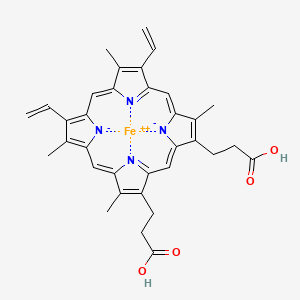

In [26]:
import urllib.request
from IPython.display import Image, display

def get_2d_image_url(cid):
    base_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{}/PNG"
    url = base_url.format(cid)
    return url

def display_2d_image(cid):
    image_url = get_2d_image_url(cid)
    image = Image(urllib.request.urlopen(image_url).read())
    display(image)

def get_chemical_name(cid):
    url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{}/property/IUPACName/txt".format(cid)
    response = urllib.request.urlopen(url)
    chemical_name = response.read().decode("utf-8").strip()
    return chemical_name

def get_synonyms(cid):
    url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{}/synonyms/TXT".format(cid)
    response = urllib.request.urlopen(url)
    synonyms = response.read().decode("utf-8").strip().split("\n")
    return synonyms

# Example usage
cid = 4973        # Example CID
chemical_name = get_chemical_name(cid)
print("Chemical Name:", chemical_name)
synonyms = get_synonyms(cid)
print("Brand Names:", synonyms)
print("Visualization of Drug structure:")
display_2d_image(cid)

In [27]:
drugs = ["Cc1c2n3c(c1CCC(=O)O)C=C4C(=C(C5=[n]4[Fe]36[n]7=C(C=C8N6C(=C5)C(=C8C)C=C)C(=C(C7=C2)C)C=C)C)CCC(=O)O","Cc1c2n3c(c1CCC(=O)O)C=C4C(=C(C5=[n]4[Fe]36[n]7=C(C=C8N6C(=C5)C(=C8C)C=C)C(=C(C7=C2)C)C=C)C)CCC(=O)O"]

In [28]:
targets=[seq,changed_seq]

In [29]:
drugs_fp = [compound_encoder.encode(drug) for drug in drugs]
targets_encoded = [protein_encoder.encode(target) for target in targets]

In [30]:
print((targets_encoded))

[[10, 13, 14, 4, 2, 1, 10, 16, 18, 1, 2, 3, 18, 10, 11, 19, 15, 1, 13, 18, 20, 2, 1, 1, 11, 3, 18, 19, 15, 1, 18, 5, 14, 10, 1, 4, 4, 10, 18, 12, 3, 1, 1, 2, 1, 14, 14, 12, 18, 18, 3, 20, 1, 3, 5, 20, 1, 14, 12, 18, 13, 19, 19, 14, 13, 1, 1, 3, 20, 18, 2, 6, 15, 14, 18, 1, 18, 5, 14, 14, 3, 5, 1, 18, 3, 1, 1, 1, 1, 13, 1, 1, 10, 19, 13, 2, 18, 14, 15, 1, 12, 3, 18, 1, 8, 2, 19, 19, 4, 3, 19, 8, 9, 18, 12, 9, 17, 14, 14, 5, 16, 1, 18, 18, 12], [10, 13, 17, 4, 2, 1, 10, 16, 18, 1, 2, 3, 17, 10, 11, 19, 15, 1, 13, 17, 20, 2, 1, 1, 11, 3, 18, 19, 15, 1, 17, 5, 14, 10, 1, 4, 4, 10, 17, 12, 3, 1, 1, 2, 1, 14, 14, 12, 17, 18, 3, 20, 1, 3, 5, 20, 1, 17, 12, 18, 13, 19, 19, 14, 13, 17, 1, 3, 20, 18, 2, 6, 17, 14, 18, 1, 18, 5, 14, 14, 3, 5, 1, 17, 3, 1, 1, 1, 1, 13, 17, 1, 10, 19, 13, 2, 17, 14, 15, 1, 12, 3, 18, 17, 8, 2, 19, 19, 4, 3, 19, 8, 9, 18, 12, 9, 17, 14, 14, 5, 16, 1, 18, 18, 12]]


In [31]:
protein_encoder = ProteinEncoder(prot_vec)
target_encoded = protein_encoder.pad(targets_encoded)

In [67]:
print(target_encoded)

[[10 13 14  4  2  1 10 16 18  1  2  3 18 10 11 19 15  1 13 18 20  2  1  1
  11  3 18 19 15  1 18  5 14 10  1  4  4 10 18 12  3  1  1  2  1 14 14 12
  18 18  3 20  1  3  5 20  1 14 12 18 13 19 19 14 13  1  1  3 20 18  2  6
  15 14 18  1 18  5 14 14  3  5  1 18  3  1  1  1  1 13  1  1 10 19 13  2
  18 14 15  1 12  3 18  1  8  2 19 19  4  3 19  8  9 18 12  9 17 14 14  5
  16  1 18 18 12]
 [10 13 17  4  2  1 10 16 18  1  2  3 17 10 11 19 15  1 13 17 20  2  1  1
  11  3 18 19 15  1 17  5 14 10  1  4  4 10 17 12  3  1  1  2  1 14 14 12
  17 18  3 20  1  3  5 20  1 17 12 18 13 19 19 14 13 17  1  3 20 18  2  6
  17 14 18  1 18  5 14 14  3  5  1 17  3  1  1  1  1 13 17  1 10 19 13  2
  17 14 15  1 12  3 18 17  8  2 19 19  4  3 19  8  9 18 12  9 17 14 14  5
  16  1 18 18 12]]


In [32]:
br_predictions = br_model.HoTS_prediction(drugs_fp, targets_encoded)

In [33]:
print("Before Mutation DTI",br_predictions[0][0])
print("After Mutation DTI",br_predictions[0][1])

Before Mutation DTI [0.28303626]
After Mutation DTI [0.41362458]
